In [338]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import joypy
import random
from datetime import datetime, timedelta, timezone

from scrape.api import DATETIME_FMT_STR
from scrape.summary import get_rows_on_date
from scrape.summary import run as generate_summary

ImportError: cannot import name 'get_rows_on_date' from 'scrape.summary' (/Users/nick.powell/code/github/nmpowell/carbon-intensity-forecast-tracking/scrape/summary.py)

In [147]:
# Produce summary data
generate_summary(input_directory="data/national_fw48h", endpoint="national_fw48h", output_directory="data")
generate_summary(input_directory="data/national_pt24h", endpoint="national_pt24h", output_directory="data")

summary_national_fw48h.csv
summary_national_pt24h.csv


In [254]:
dffw = pd.read_csv("data/summary_national_fw48h.csv", index_col=0, header=[0,1])
dfpt = pd.read_csv("data/summary_national_pt24h.csv", index_col=0, header=[0,1])
dfpt

intensity.forecast                                          \
time_difference                -00.5  -01.0  -01.5  -02.0  -02.5 -03.0 -03.5   
2023-03-13T03:00Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T03:30Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T04:00Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T04:30Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
2023-03-13T05:00Z                NaN    NaN    NaN    NaN    NaN   NaN   NaN   
...                              ...    ...    ...    ...    ...   ...   ...   
2023-03-26T16:00Z              137.0  137.0  137.0  137.0  137.0   NaN   NaN   
2023-03-26T16:30Z              146.0  146.0  146.0  146.0    NaN   NaN   NaN   
2023-03-26T17:00Z              153.0  153.0  153.0    NaN    NaN   NaN   NaN   
2023-03-26T17:30Z              153.0  153.0    NaN    NaN    NaN   NaN   NaN   
2023-03-26T18:00Z              150.0    NaN    NaN    NaN    NaN   NaN   NaN   

                                     ... intensity.actual                    \
time_difference   -04.0 -04.5 -05.0  ...            -19.5 -20.0 -20.5 -21.0   
2023-03-13T03:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T03:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T04:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T04:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-13T05:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
...                 ...   ...   ...  ...              ...   ...   ...   ...   
2023-03-26T16:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-26T16:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-26T17:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-26T17:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-26T18:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   

                                                       
time_difference   -21.5 -22.0 -22.5 -23.0 -23.5 -24.0  
2023-03-13T03:00Z   NaN   NaN   NaN   NaN   NaN  64.0  
2023-03-13T03:30Z   NaN   NaN   NaN   NaN  64.0  64.0  
2023-03-13T04:00Z   NaN   NaN   NaN  56.0  56.0  56.0  
2023-03-13T04:30Z   NaN   NaN  58.0  58.0  58.0  58.0  
2023-03-13T05:00Z   NaN  62.0  62.0  62.0  62.0  62.0  
...                 ...   ...   ...   ...   ...   ...  
2023-03-26T16:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-26T16:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-26T17:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-26T17:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-26T18:00Z   NaN   NaN   NaN   NaN   NaN   NaN  

[634 rows x 96 columns]

In [316]:
merged_df = pd.merge(dffw, dfpt, left_index=True, right_index=True, how="outer")

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    new_df = df.copy()
    new_df.index = pd.to_datetime(new_df.index)
    
    # one subset of columns in a multi-index
    new_df.columns = new_df.columns.set_levels(new_df.columns.levels[1].astype(float), level=1)
    new_df = new_df.reindex(sorted(new_df.columns, reverse=True), axis=1)
    return new_df

merged_df = format_dataframe(merged_df)


# merged_df.index = pd.to_datetime(merged_df.index)

# Set columns to float and sort

# whole dataframe
# dfif.columns = dfif.columns.astype(float)
# dfif = dfif.reindex(sorted(dfif.columns), axis=1)
merged_df

intensity.forecast                                 \
time_difference                         47.5   47.0  46.5  46.0  45.5  45.0   
2023-03-13 03:00:00+00:00                NaN    NaN   NaN   NaN   NaN   NaN   
2023-03-13 03:30:00+00:00                NaN    NaN   NaN   NaN   NaN   NaN   
2023-03-13 04:00:00+00:00                NaN    NaN   NaN   NaN   NaN   NaN   
2023-03-13 04:30:00+00:00                NaN    NaN   NaN   NaN   NaN   NaN   
2023-03-13 05:00:00+00:00                NaN    NaN   NaN   NaN   NaN   NaN   
...                                      ...    ...   ...   ...   ...   ...   
2023-03-28 16:00:00+00:00               92.0   92.0  92.0  92.0  92.0   NaN   
2023-03-28 16:30:00+00:00               97.0   97.0  97.0  97.0   NaN   NaN   
2023-03-28 17:00:00+00:00               99.0   98.0  98.0   NaN   NaN   NaN   
2023-03-28 17:30:00+00:00              103.0  103.0   NaN   NaN   NaN   NaN   
2023-03-28 18:00:00+00:00              105.0    NaN   NaN   NaN   NaN   NaN   

                                                   ... intensity.actual        \
time_difference            44.5  44.0  43.5  43.0  ...            -19.5 -20.0   
2023-03-13 03:00:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-13 03:30:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-13 04:00:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-13 04:30:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-13 05:00:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
...                         ...   ...   ...   ...  ...              ...   ...   
2023-03-28 16:00:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-28 16:30:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-28 17:00:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-28 17:30:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   
2023-03-28 18:00:00+00:00   NaN   NaN   NaN   NaN  ...              NaN   NaN   

                                                                           
time_difference           -20.5 -21.0 -21.5 -22.0 -22.5 -23.0 -23.5 -24.0  
2023-03-13 03:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN  64.0  
2023-03-13 03:30:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN  64.0  64.0  
2023-03-13 04:00:00+00:00   NaN   NaN   NaN   NaN   NaN  56.0  56.0  56.0  
2023-03-13 04:30:00+00:00   NaN   NaN   NaN   NaN  58.0  58.0  58.0  58.0  
2023-03-13 05:00:00+00:00   NaN   NaN   NaN  62.0  62.0  62.0  62.0  62.0  
...                         ...   ...   ...   ...   ...   ...   ...   ...  
2023-03-28 16:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-28 16:30:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-28 17:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-28 17:30:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-28 18:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[751 rows x 288 columns]

<Axes: xlabel='time_difference'>

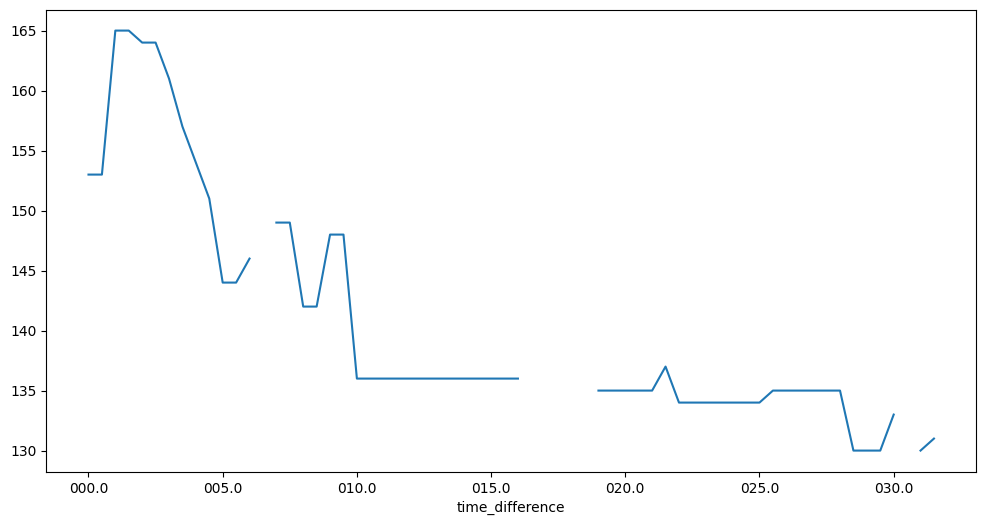

In [256]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
dffw["intensity.forecast"].loc["2023-03-26T18:30Z"].plot()

We will show forecasts from 48 hours before the chosen start date, and also post-hoc "forecasts" and "actual" values taken for 24 hours after that date.

We do this for several hours' worth of data (several time-points) after the chosen start date:

In [257]:
hours_prior_to_now = 120

dt_now = datetime.utcnow().replace(tzinfo=timezone.utc).strftime(DATETIME_FMT_STR)
dt_pastpoint = datetime.utcnow().replace(tzinfo=timezone.utc) - timedelta(hours=hours_prior_to_now)
hours_of_data = 12

print(f"Date now: {dt_now}\nStart date for analysis: {dt_pastpoint}")

Date now: 2023-03-27T03:34Z
Start date for analysis: 2023-03-22 03:34:03.572280+00:00


Will plot 24 half-hourly timepoints starting from 120 hours ago, 2023-03-22 03:34:03.572280+00:00


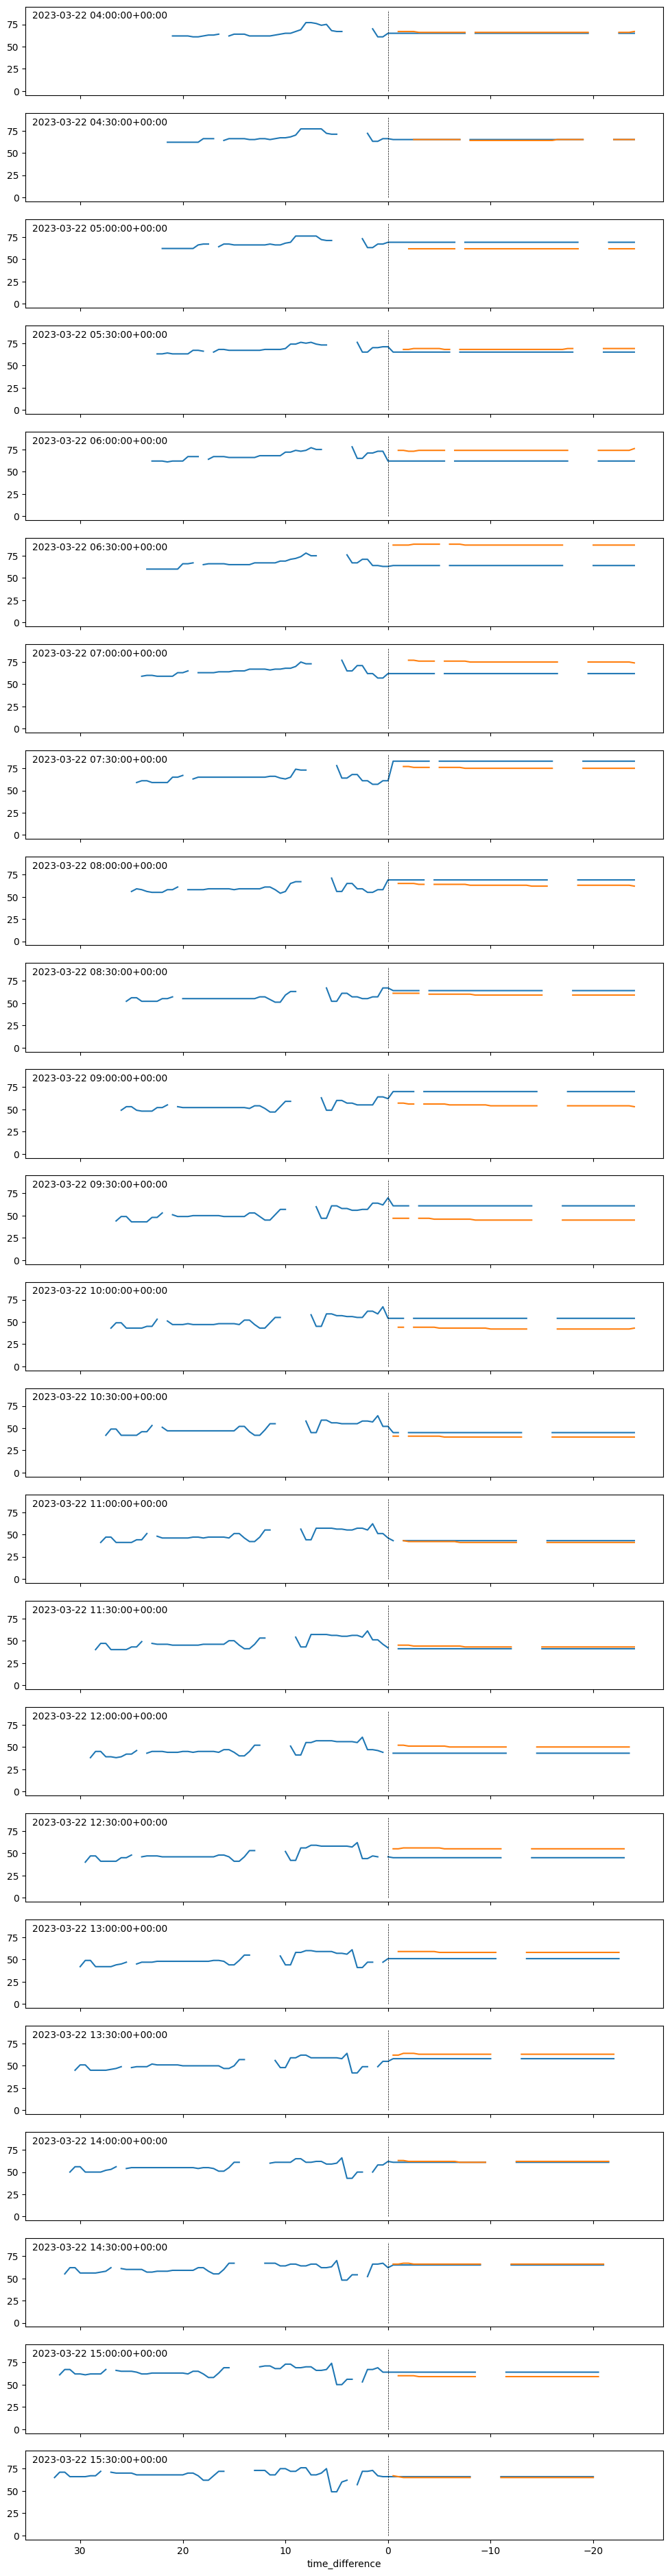

In [258]:
# Time-points are half-hourly so need twice the rows as hours covered
nrows = hours_of_data * 2
dates = [d for d in merged_df.index if d >= dt_pastpoint][:nrows]
print(f"Will plot {nrows} half-hourly timepoints starting from {hours_prior_to_now} hours ago, {dt_pastpoint}")

# Alternatively plot some random dates
# dates = random.choices(merged_df.index, k=nrows)

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(nrows, 1, sharex=True, sharey="col")
for ix, ax in enumerate(axes):
    merged_df["intensity.forecast"].loc[dates[ix]].plot(ax=ax)
    merged_df["intensity.actual"].loc[dates[ix]].plot(ax=ax)
    ax.text(0.01, 0.95, dates[ix], horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
    
plt.gca().invert_xaxis()
ymax = plt.gca().get_ylim()[-1]

for ix, ax in enumerate(axes):
    ax.vlines(0.0,0,ymax, color='k', linestyle='--', linewidth=0.5)

plt.show()

Odd in the above that the post-hoc "forecast" value appears to be constant after about 30 minutes after the selected time-point, but the "actual" value continues to change.

The final forecast value doesn't appear until about 30 minutes after the start of the window; same with the "actual" value, which is only available after the end of the given window.

In [330]:
# Use only forecasts for measuring prediction quality

forecast_df = format_dataframe(dffw)

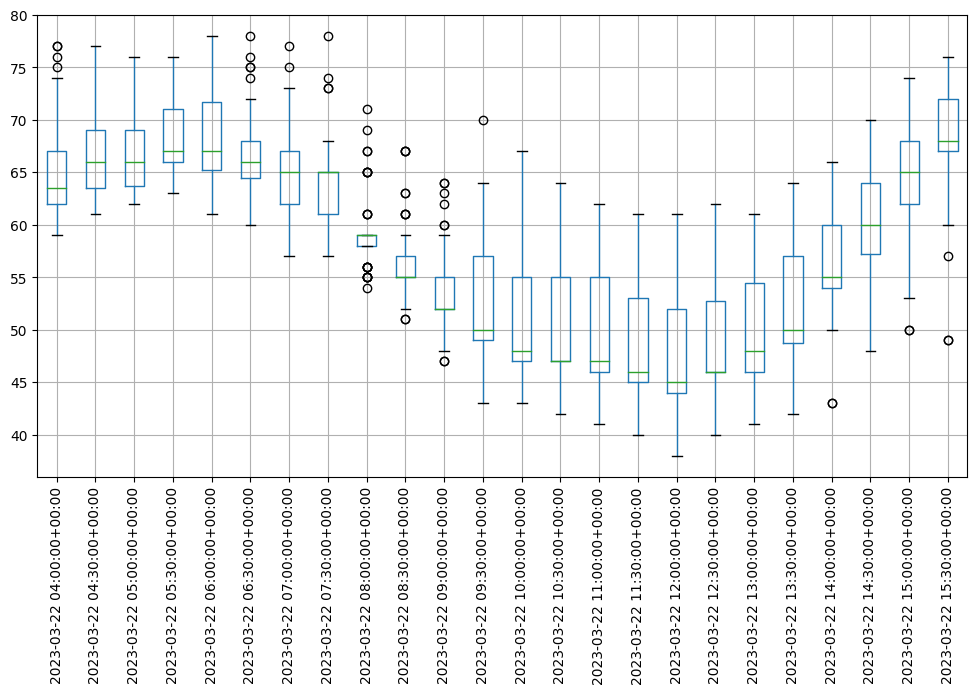

In [331]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

ax = forecast_df["intensity.forecast"].loc[dates].T.boxplot(rot=90)

In [336]:
dt = (datetime.utcnow().astimezone(timezone.utc) - timedelta(days=7))

In [337]:
get_rows_on_date(forecast_df["intensity.forecast"], dt)

time_difference,47.5,47.0,46.5,46.0,45.5,45.0,44.5,44.0,43.5,43.0,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
2023-03-20,218.0,215.0,NaN,215.0,215.0,215.0,216.0,208.0,206.0,206.0,...,163.0,167.0,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,214.0,NaN,214.0,214.0,214.0,216.0,210.0,206.0,206.0,200.0,...,167.0,164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,NaN,213.0,213.0,214.0,215.0,209.0,205.0,205.0,199.0,199.0,...,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,211.0,211.0,211.0,212.0,205.0,203.0,203.0,197.0,197.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,208.0,208.0,209.0,203.0,202.0,202.0,199.0,199.0,201.0,201.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,206.0,207.0,200.0,200.0,200.0,195.0,196.0,200.0,199.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,205.0,198.0,198.0,198.0,194.0,195.0,200.0,199.0,200.0,200.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,195.0,197.0,197.0,191.0,192.0,198.0,198.0,198.0,198.0,197.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,195.0,195.0,194.0,194.0,199.0,198.0,198.0,198.0,198.0,199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-20,192.0,189.0,190.0,196.0,196.0,196.0,196.0,196.0,197.0,197.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Comparison with "actual"

In [265]:
# Take a single value as the "actual"

merged_df["actual"] = merged_df["intensity.actual"].mean(axis=1)
merged_df["actual_median"] = merged_df["intensity.actual"].median(axis=1)

dfif = merged_df["intensity.forecast"]

df_forecasts_posthoc = dfif[[c for c in dfif.columns if float(c) < 0.0]]
merged_df["actual_forecast"] = df_forecasts_posthoc[-1.0]

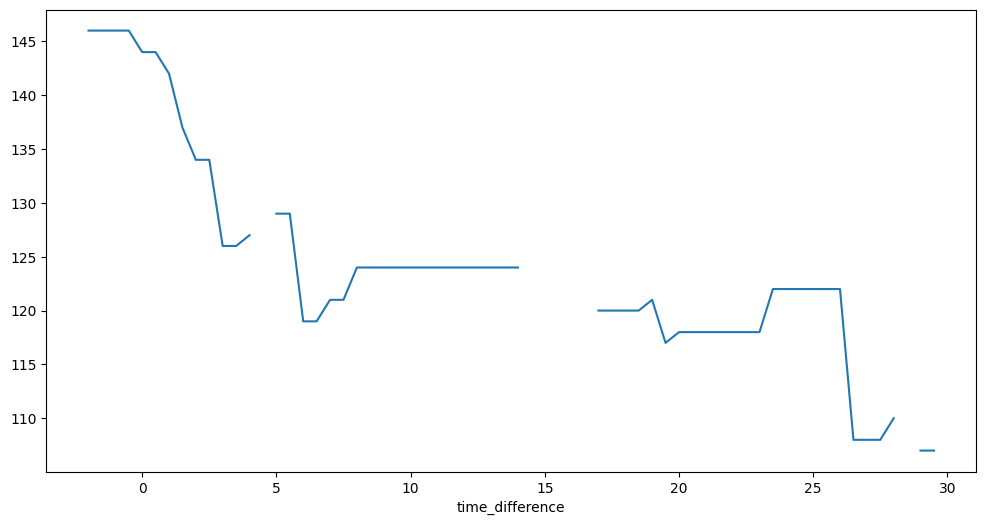

In [266]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
ax = dfif.iloc[-100].plot()

In [267]:
dfsub = merged_df["intensity.forecast"].sub(merged_df["actual"], axis=0)
dfsub_pc = dfsub / merged_df["intensity.forecast"]

dfsub_forecasts = merged_df["intensity.forecast"].sub(merged_df["actual_forecast"], axis=0)
dfsub_fc_pc = dfsub_forecasts / merged_df["intensity.forecast"]

The following Joy / Ridgeline plots are histograms taken across all available data.

For each of the 96 half-hourly timepoints prior to any given target window, we count into a histogram bin if the forecast has this much % error from the final forecast or mean "actual" value (which, confusingly, can change).

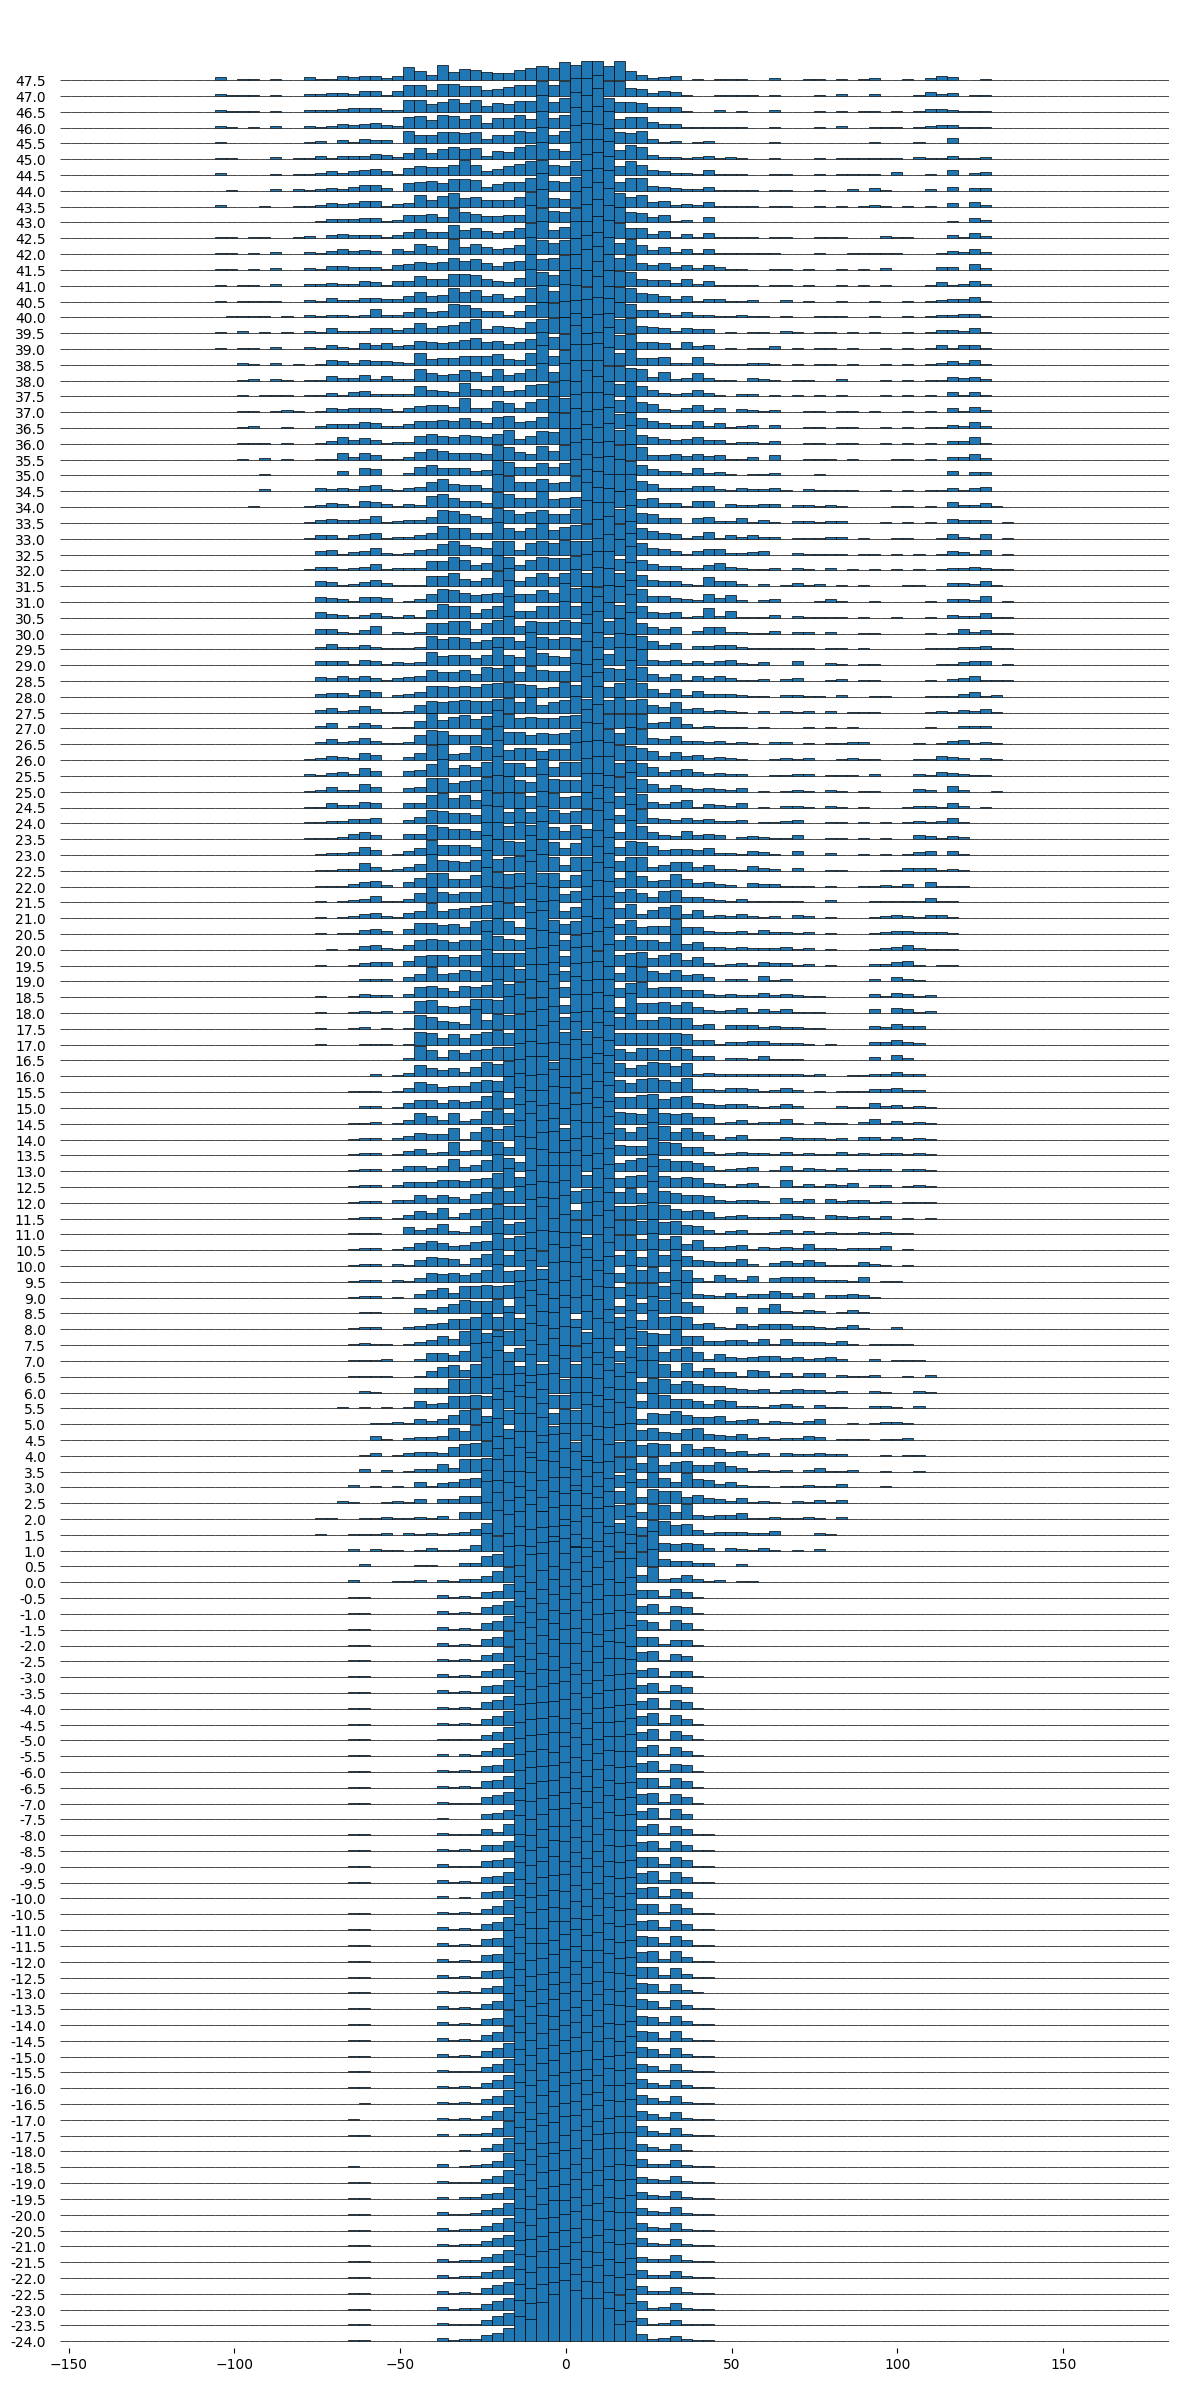

In [268]:
plt.rcParams['figure.figsize'] = [12, 24]
plt.rcParams['figure.dpi'] = 100

# Plot histograms of the actual data differences
# fig, ax = joypy.joyplot(dfsub, linewidth=0.5)
fig, ax = joypy.joyplot(dfsub, hist=True, bins=100, linewidth=0.5)

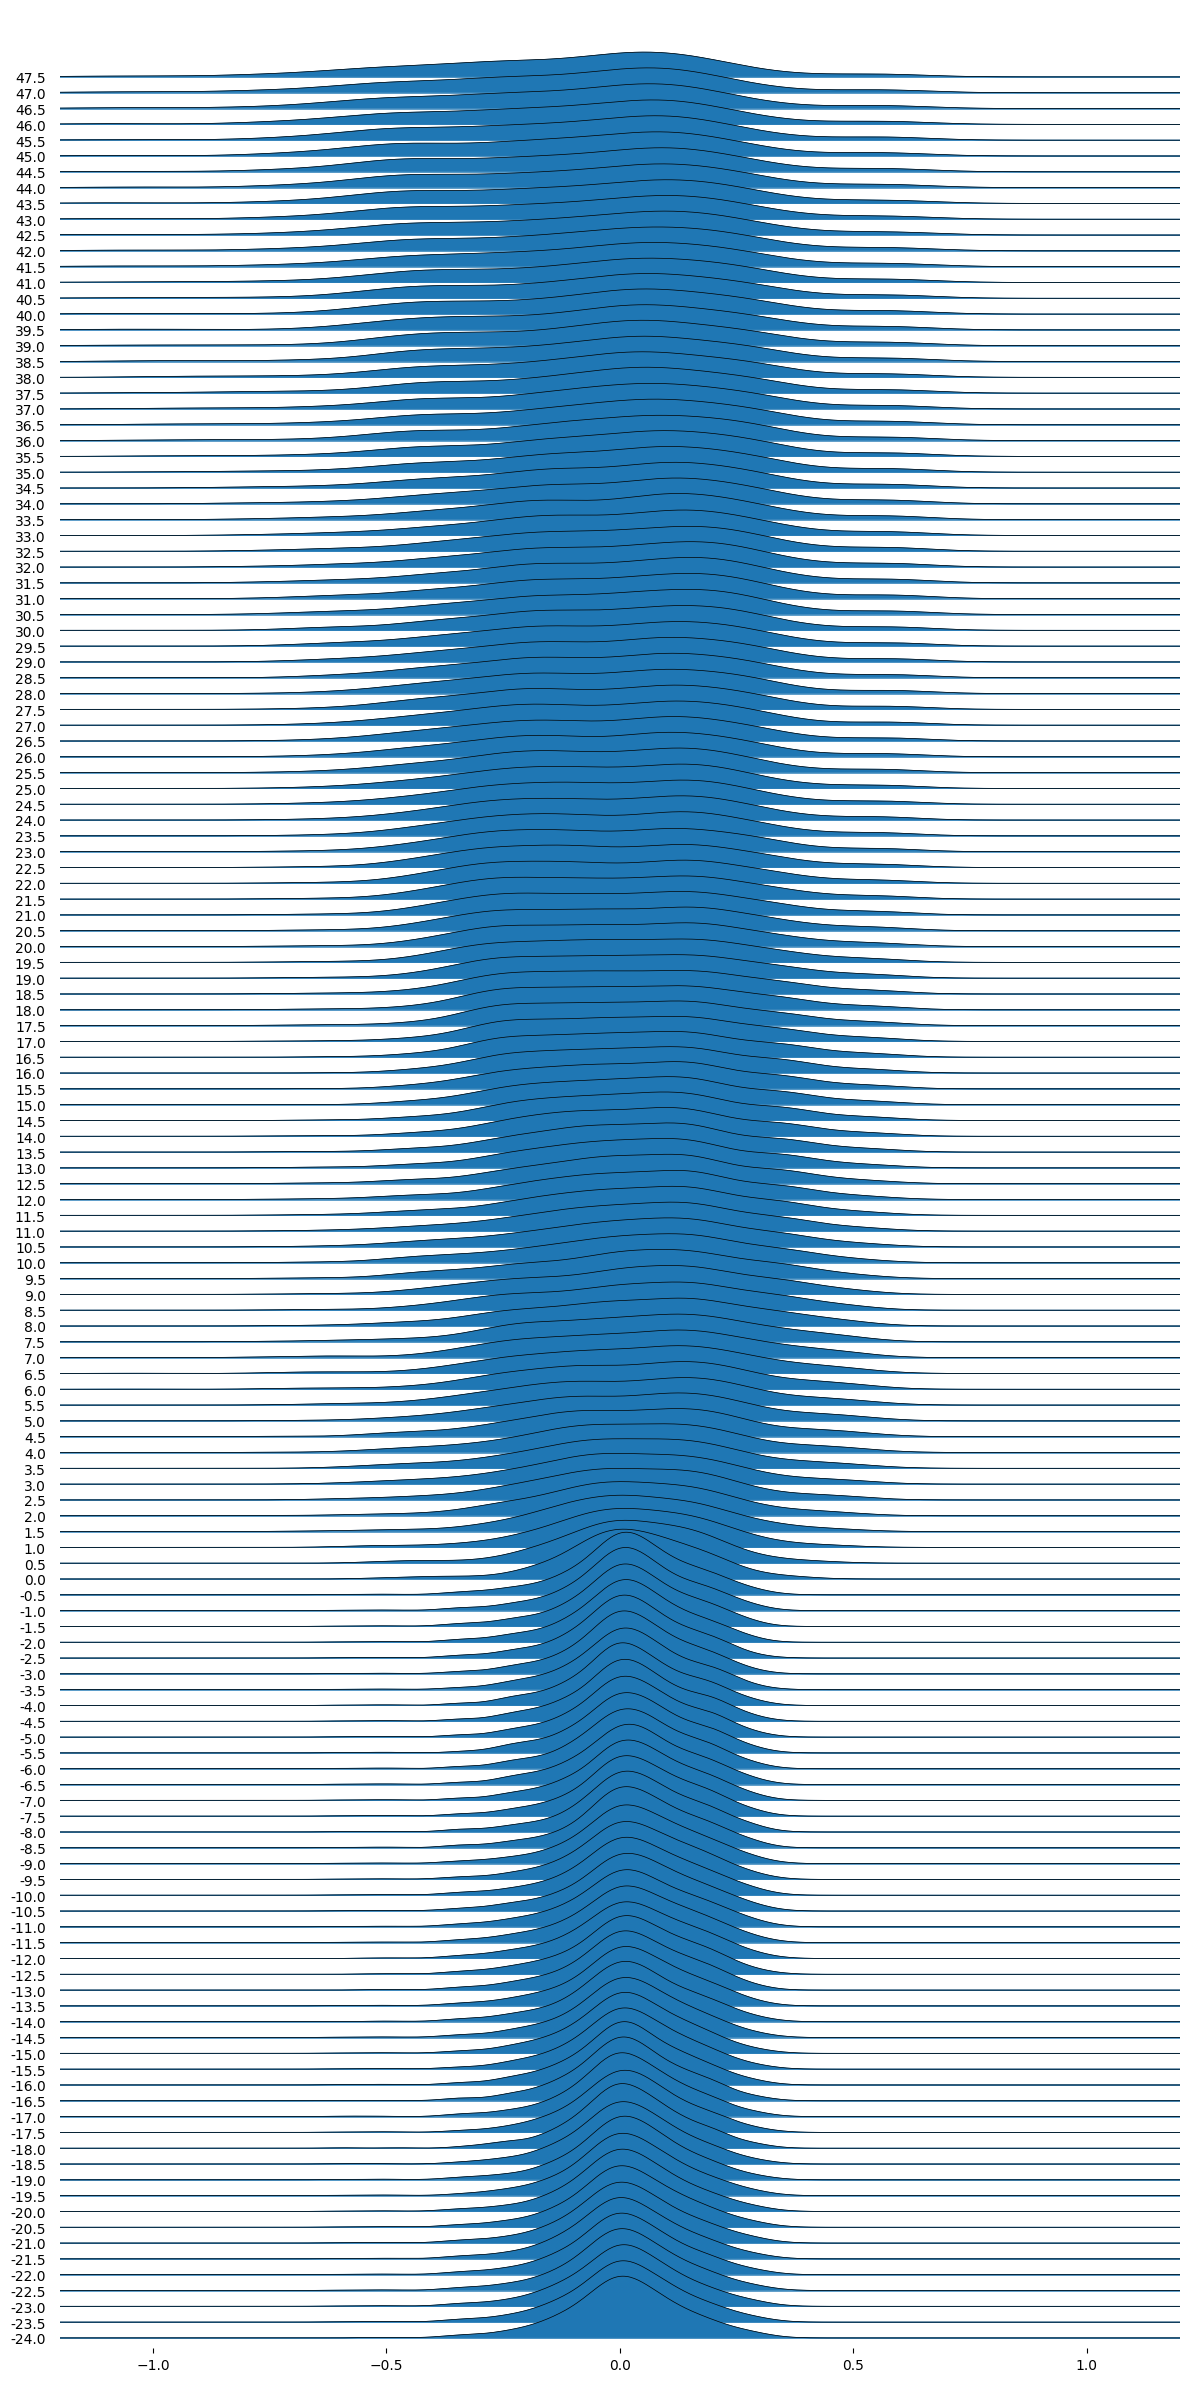

In [269]:
# Show a smoothed plot of the relative difference between the forecast and the mean "actual" value after.
fig, axes = joypy.joyplot(dfsub_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

/Users/nick.powell/.virtualenvs/carbon-intensity-forecast-tracking/lib/python3.10/site-packages/joypy/joyplot.py:286: UserWarning: The data contains a group with a single distinct value (0.0) having infinite probability density. Consider using a different visualization.
  warnings.warn("The data contains a group with a single distinct value ({}) "


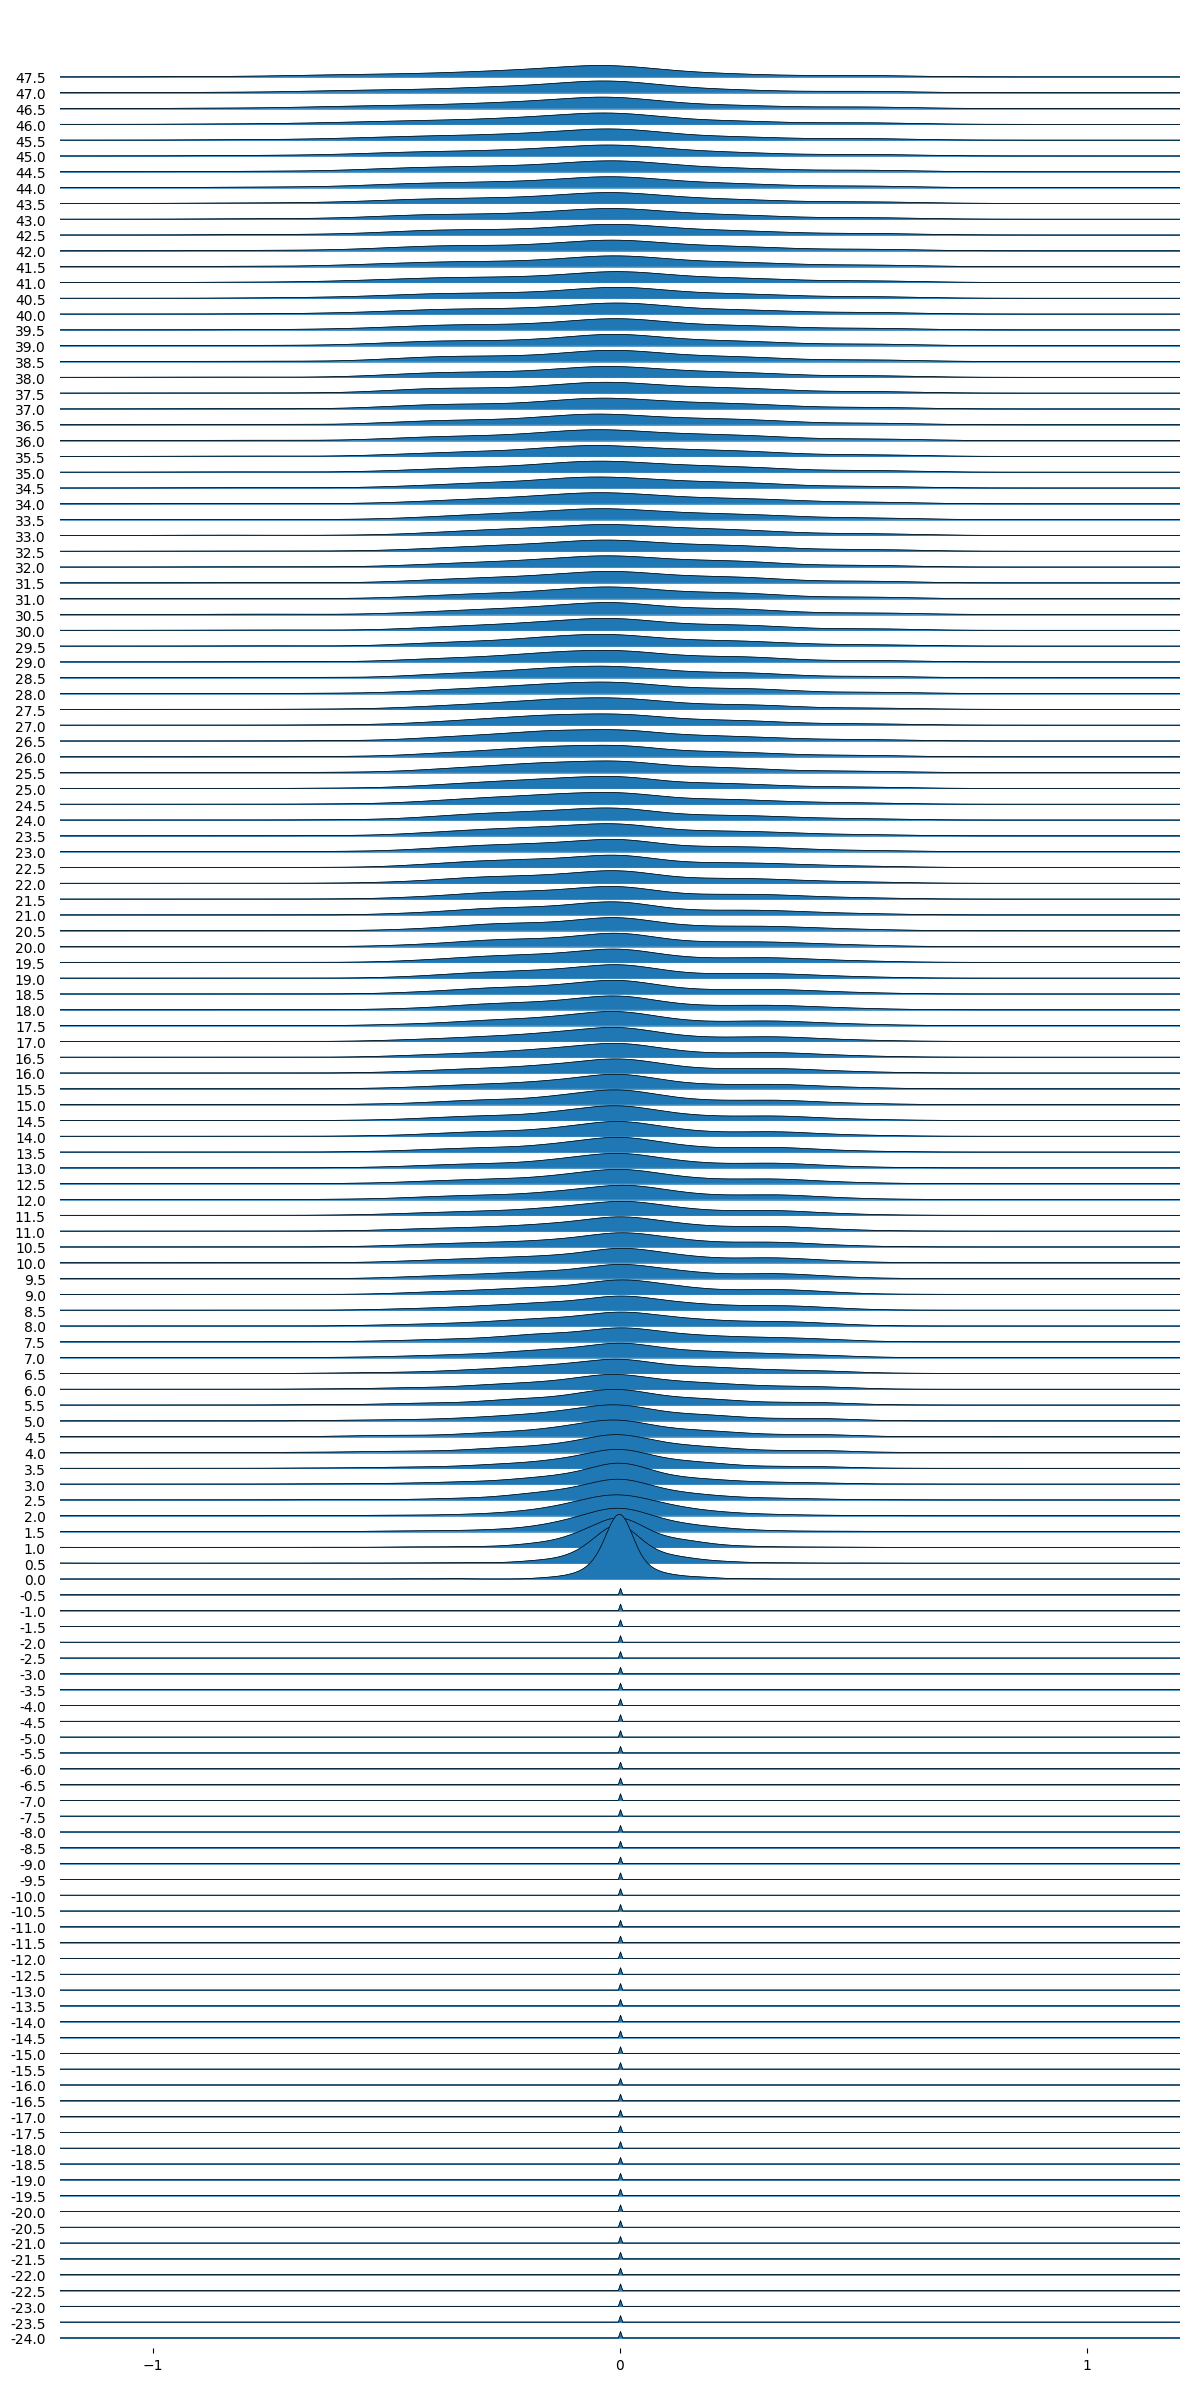

In [270]:
fig, axes = joypy.joyplot(dfsub_fc_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

In the above, we show that forecasts are _not great_. A deviation of +/- 1.0 represents a 100% error on the actual value. We can also show the mean and standard deviation percentage errors for each forecasting half-hour.

In [274]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

(48.0, -24.0)

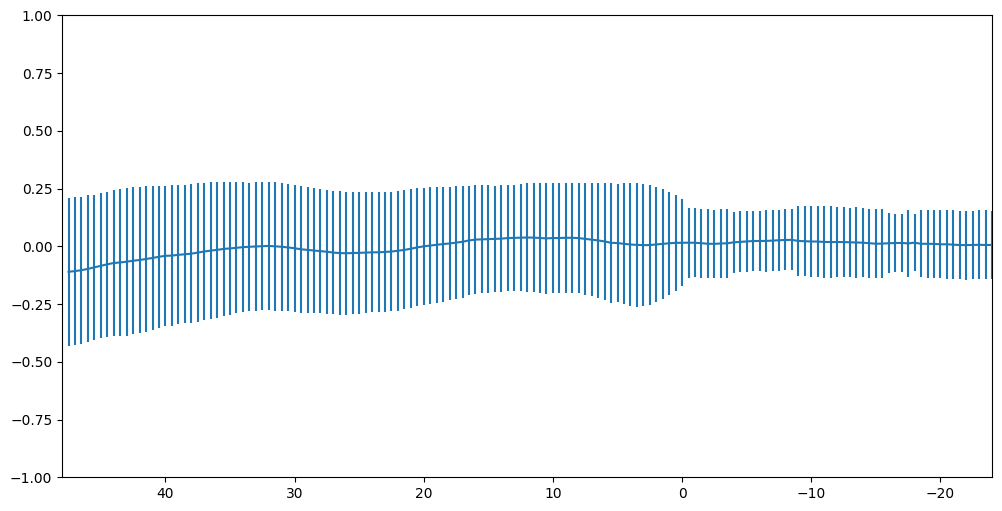

In [275]:
means = pd.DataFrame(dfsub_pc.mean(axis=0)).rename(columns={0: "mean"})
stdevs = pd.DataFrame(dfsub_pc.std(axis=0)).rename(columns={0: "stdev"})
mean_std = pd.concat([means, stdevs], axis=1).reset_index()
mean_std = mean_std.apply(pd.to_numeric, errors='coerce')
ax = plt.errorbar("time_difference", "mean", yerr="stdev", data=mean_std)
plt.ylim(-1., 1.)
plt.xlim(48., -24.)

(48.0, -24.0)

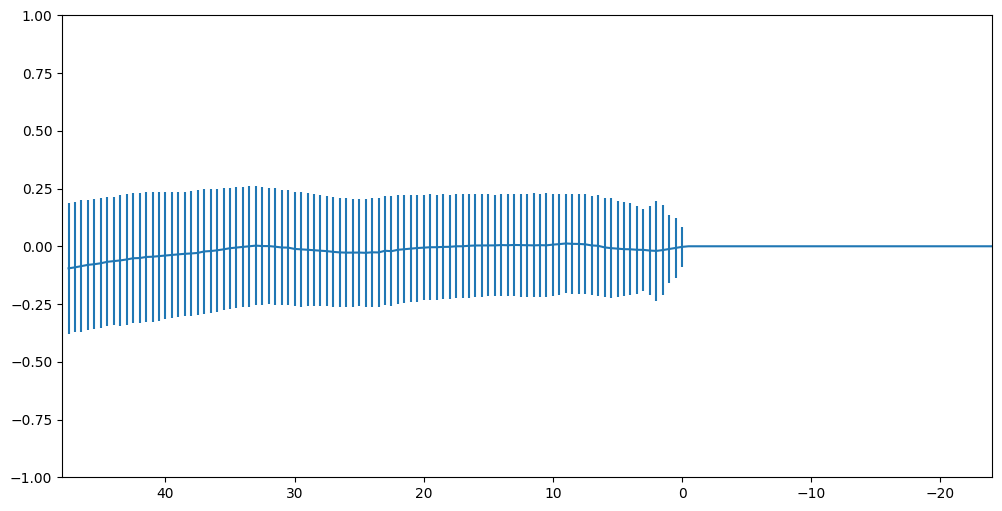

In [276]:
means = pd.DataFrame(dfsub_fc_pc.mean(axis=0)).rename(columns={0: "mean"})
stdevs = pd.DataFrame(dfsub_fc_pc.std(axis=0)).rename(columns={0: "stdev"})
mean_std = pd.concat([means, stdevs], axis=1).reset_index()
mean_std = mean_std.apply(pd.to_numeric, errors='coerce')
ax = plt.errorbar("time_difference", "mean", yerr="stdev", data=mean_std)
plt.ylim(-1., 1.)
plt.xlim(48., -24.)

time_difference
 47.5    31.987646
 47.0    32.015440
 46.5    31.853972
 46.0    31.771304
 45.5    31.473868
           ...    
-22.0    14.924925
-22.5    14.893203
-23.0    14.921892
-23.5    14.937519
-24.0    14.704628
Length: 144, dtype: float64


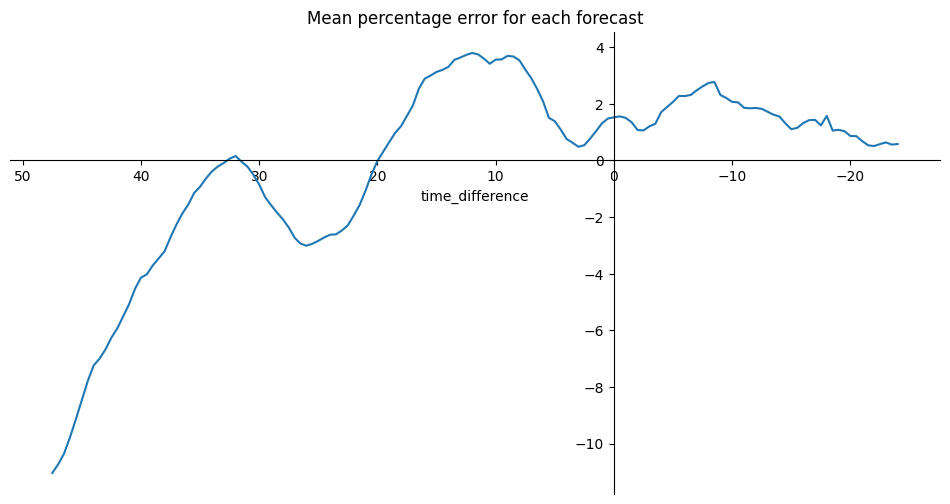

In [277]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
ax = (dfsub_pc.mean(axis=0) * 100.).plot(title="Mean percentage error for each forecast")
ax.invert_xaxis()

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
# ax.vlines("0.0", ax.get_ylim()[0],ax.get_ylim()[1], color='k', linestyle='--', linewidth=0.5)

print(dfsub_pc.std(axis=0) * 100.)